In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import SimpleITK as sitk

import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from transformers import get_cosine_schedule_with_warmup

import matplotlib.pyplot as plt

In [2]:
from dataset.augmentation import flip
from dataset.preprocessing import whitening

from models.resnet_3d import r3d_18, test_r3d_18
test_r3d_18()

# Data

In [3]:
root_path = Path(os.getcwd())
dataset_path = root_path.parent/'dataset_V86'

In [4]:
df = pd.read_csv(dataset_path/'targets.csv', index_col=0)

In [5]:
df

,file,target
0,0.npy,59
1,1.npy,59
2,10.npy,86
3,11.npy,86
4,12.npy,86
...,...,...
81,45.npy,29
82,46.npy,29
83,47.npy,29
84,48.npy,25


In [6]:
all_pairs = [ (str(dataset_path/'npys'/df.iloc[i]['file']), df.iloc[i]['target']) for i in range(len(df))]
# (abs apth, age)

torch.Size([1, 64, 64, 64]) tensor([59.])
tensor([59.]) torch.FloatTensor


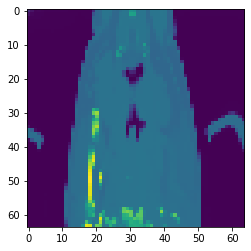

In [7]:
class DICOMDataset(Dataset):
    def __init__(self, pairs, out_size, mode='test'):
        self.pairs = pairs
        self.out_size = out_size
        self.mode = mode

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, i):
        file_path, target = self.pairs[i]
        image = np.load(file_path)
        image = whitening(image)
        if self.mode == 'train':
            image = flip(image).copy()
            
        image  = ToTensor()(image).unsqueeze(0).type(torch.FloatTensor).unsqueeze(0)
        target = torch.tensor([target]).type(torch.FloatTensor)

        d = torch.linspace(-1, 1, self.out_size)
        meshx, meshy, meshz = torch.meshgrid((d, d, d))
        grid = torch.stack((meshx, meshy, meshz), 3)
        grid = grid.unsqueeze(0) # add batch dim
        image = F.grid_sample(image, grid, align_corners=True)

        return image.squeeze(0), target


ds = DICOMDataset(all_pairs, 64, 'train')
img, label = ds[0]
print(img.shape, label)
print(label, img.type())
plt.imshow(img[0][30])

# Train

In [8]:
def train_epoch(model, loader, optimizer, loss_fn, scheduler, device='cuda'):
    running_loss = 0
    number_of_samples = 0
    
    pbar = tqdm(total = len(loader), desc='Training')
    for _, (images, targets) in enumerate(loader):
        
        images, targets = images.to(device), targets.to(device)
        model.train()
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()*images.shape[0]
        number_of_samples += images.shape[0]
        pbar.update()
        
    pbar.close()
    return running_loss/number_of_samples


def test_model(model, test_dataset, batch_size=8, verbose=False, device='cuda'):
    testloader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size, num_workers=0)
    
    all_prediction = []
    all_targets = []
    pbar = tqdm(total = len(testloader), desc='Testing')
    with torch.no_grad():
        for _, (images, targets) in enumerate(testloader):
            model.eval()
            all_prediction += model(images.to(device)).cpu().numpy().tolist()
            all_targets    += targets.cpu().numpy().tolist()
            pbar.update()
        
    pbar.close()
    return torch.nn.MSELoss()(torch.tensor(all_prediction), torch.tensor(all_targets))


def train_test(
    model,
    train_dataset,
    test_dataset,
    num_epochs=30, 
    batch_size=8, 
    verbose=False, 
    device='cuda',
    lr=0.001,
):
    trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)

    optimizer = Adam(model.parameters(), lr = lr) #, weight_decay = 1e-3)
    num_train_steps = int(len(train_dataset) / batch_size * num_epochs)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/batch_size*5, num_training_steps=num_train_steps)
    loss_fn = torch.nn.MSELoss()

    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, trainloader, optimizer, loss_fn, scheduler, device)
        train_losses.append(train_loss)

        test_loss = test_model(model, test_dataset, batch_size, verbose, device)
        test_losses.append(test_loss)
        
        if verbose:
            tqdm.write('Epoch: '+ str(epoch) + ', Train loss: ' + str(train_loss) + ', Test loss: ' + str(test_loss))
    
    return train_losses, test_losses

In [9]:
train_test_delimeter = int(len(all_pairs)*0.7)
random.shuffle(all_pairs)

train_dataset = DICOMDataset(all_pairs[:train_test_delimeter], 112, 'train')
test_dataset  = DICOMDataset(all_pairs[train_test_delimeter:], 112, 'test')

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = r3d_18(1, device)

# model = torch.load("V_model_no_norm.pth")
# model.to(device)
print()

In [11]:
train_loss, test_loss = train_test(
    model, 
    train_dataset,
    test_dataset,
    batch_size=16,
    verbose=True, 
    num_epochs=1, # 200 is ok
    device=device,
    lr=0.01,
)

torch.save(model, "resnet_3d_V86_0.pth")

Testing: 100%|██████████| 2/2 [00:14<00:00,  7.17s/it]

Epoch: 0, Train loss: 2476.342325846354, Test loss: tensor(2639.7722)


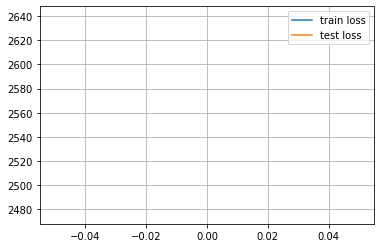

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(test_loss)), test_loss, label='test loss')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [13]:
train_pairs = []

model.cpu()
model.eval()
with torch.no_grad():
    for i in tqdm(range(len(train_dataset))):
        img, tgt = train_dataset[i]        
        pred = model(img.unsqueeze(0).cpu()).cpu()
        train_pairs.append([tgt[0].item(), pred[0][0].item()])
#         print(train_pairs[-1])

100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


In [14]:
test_pairs = []

model.cpu()
model.eval()
with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        img, tgt = test_dataset[i]        
        pred = model(img.unsqueeze(0).cpu()).cpu()
        test_pairs.append([tgt[0].item(), pred[0][0].item()])
#         print(test_pairs[-1])

100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


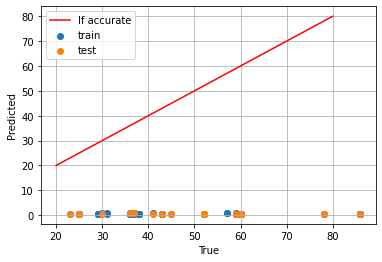

In [15]:
import matplotlib.pyplot as plt

plt.scatter([p[0] for p in train_pairs], [p[1] for p in train_pairs], label='train')
plt.scatter([p[0] for p in test_pairs], [p[1] for p in test_pairs], label='test')
plt.plot([20, 80], [20, 80], color='r', label='If accurate')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.legend()
plt.grid()
plt.show()
plt.close()

In [16]:
tru = [p[0] for p in train_pairs]
pre = [p[1] for p in train_pairs]
(np.array(tru)-np.array(pre)).std()

16.825821091605565

In [17]:
tru = [p[0] for p in test_pairs]
pre = [p[1] for p in test_pairs]
(np.array(tru)-np.array(pre)).std()

15.816232740894812

In [18]:
data = {}
data['train_samples'] = [{'true': p[0], 'predicted': p[1]} for p in train_pairs]
data['test_samples'] = [{'true': p[0], 'predicted': p[1]} for p in test_pairs]

import json
with open(file="predicted.json", mode='w') as f:
    json.dump(data, f, indent=2)